# Optical Music Recognition
**By: Sarah Alabdulwahab & Asma Althakafi**
> Optical Music Recognition (OMR) is software that essentially teaches the machine to read sheet music. The aim of this project is to develop a sheet music reader which will classify each music note then produce an audio file of the music it read.

In [1]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm
import numpy as np
from pre_processing import *
from scipy.ndimage import binary_fill_holes
from skimage.morphology import thin

#Predefined models from github.com/aashrafh
from commonfunctions import *
from staff import coordinator
from segmenter import Segmenter
from connected_componentes import *
from fit import predict
from box import Box

#NN
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, InputLayer

# web scraping imports
import requests
from bs4 import BeautifulSoup

# audio file
from scipy.io.wavfile import write

In [2]:
label_map = {0:{0: 'N0'}, 1:{0:'b4',1:'a4'}, 2:{0:'g4',1:'f4'}, 3:{0:'e4',1:'d4'}, 4:{0:'c4',1:'b3'}, 
             5:{0:'a3',1:'g3'}, 6:{0:'f3',1:'e3'}, 7:{0:'d3',1:'c3'}}

## Image Recognition & Cleaning

In [3]:
def read_all_images(num_of_images):
    all_images_list = []
    for i in range(num_of_images):
        path = f'Notes/music sheet ({i+1}).png'
        img = gray_img(io.imread(path))
        all_images_list.append(get_thresholded(img, threshold_otsu(img)))
    return all_images_list

In [4]:
def segmenting(img):
    segmenter = Segmenter(get_thresholded(img, threshold_otsu(img))) #binary image
    imgs_with_staff = segmenter.regions_with_staff
    imgs_spacing, imgs_rows, coord_imgs  = [], [], []
    for i, img in enumerate(imgs_with_staff):
        spacing, rows, no_staff_img = coordinator(img,IsHorizontal(img))
        imgs_rows.append(rows)
        imgs_spacing.append(spacing)
        coord_imgs.append(no_staff_img)
    return segmenter, imgs_spacing, imgs_rows, coord_imgs, imgs_with_staff

In [5]:
def estim(c, idx, imgs_spacing, imgs_rows):
    spacing = imgs_spacing[idx]
    rows = imgs_rows[idx]
    margin = 1+(spacing/4)
    for index,line in enumerate (rows):
        if c >= line - margin and c <= line + margin:
            return index+1, 0
        elif c >= line + margin and c <= line + 3*margin:
            return index+1, 1
    return 0, 0 

In [6]:
def filter_beams(prims, prim_with_staff, bounds):
    n_bounds, n_prims, n_prim_with_staff = [], [], []
    for i, prim in enumerate(prims):
        if prim.shape[1] >= 2*prim.shape[0]:
            continue
        else:
            n_bounds.append(bounds[i])
            n_prims.append(prims[i])
            n_prim_with_staff.append(prim_with_staff[i])
    return n_prims, n_prim_with_staff, n_bounds

## Data Collection

In [7]:
def get_labeled_data(img):
    labels_list, images_list = [], []
    segmenter, imgs_spacing, imgs_rows, coord_imgs, imgs_with_staff = segmenting(img)
    black_names = ['4', '8', '8_b_n', '8_b_r', '16', '16_b_n', '16_b_r', '32', '32_b_n', '32_b_r', 'a_4', 
                   'a_8', 'a_16', 'a_32', 'chord']
    disk_size = segmenter.most_common / 4
    for i, img in enumerate(coord_imgs):
        primitives, prim_with_staff, boundary = get_connected_components(img, imgs_with_staff[i])
        for j, prim in enumerate(primitives):
            prim = binary_opening(prim, square(segmenter.most_common-imgs_spacing[i]))
            label = predict((255*(1 - prim)).astype(np.uint8))[0]
            if label in black_names:
                test_img = binary_dilation(np.copy(prim_with_staff[j]), disk(disk_size))
                comps, comp_w_staff, bounds = get_connected_components(test_img, prim_with_staff[j])
                comps, comp_w_staff, bounds = filter_beams(comps, comp_w_staff, bounds)
                bounds = [np.array(bound)+disk_size-2 for bound in bounds]
                if len(bounds) <= 1 or label in ['8_b_n', '8_b_r', '16_b_n', '16_b_r', '32_b_n', '32_b_r']:
                    for bbox in bounds:
                        line_idx, p = estim(int(bbox[2]+boundary[j][0]), i, imgs_spacing, imgs_rows)
                        labels_list.append(label_map[line_idx][p])
                        images_list.append(prim_with_staff[j])
            elif label in ['2', 'a_2']:
                head_img = binary_closing(1-binary_fill_holes(1-prim), disk(disk_size))
                comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
                for bbox in bounds:
                    line_idx, p = estim(int(bbox[2]+boundary[j][0]), i, imgs_spacing, imgs_rows)
                    labels_list.append(label_map[line_idx][p])
                    images_list.append(prim_with_staff[j])
            elif label in ['1', 'a_1']:
                line_idx, p = estim(int(boundary[j][2]), i, imgs_spacing, imgs_rows)
                labels_list.append(label_map[line_idx][p])
                images_list.append(prim_with_staff[j])
    return labels_list, images_list

In [8]:
all_images = read_all_images(5000)
all_images_labels, all_images_arr, all_images_ids =[], [], []
for i, image in tqdm(enumerate(all_images)):
    labels_list, images_list = get_labeled_data(image)
    all_images_labels += labels_list
    all_images_arr += images_list
    all_images_ids += [i] * len(labels_list)

5000it [5:08:51,  3.71s/it]


In [9]:
#view some labels
print(all_images_labels[:20])

['c4', 'c4', 'g4', 'g4', 'a4', 'a4', 'g4', 'g4', 'f4', 'f4', 'e4', 'e4', 'd4', 'd4', 'e4', 'c4', 'g4', 'g4', 'f4', 'f4']


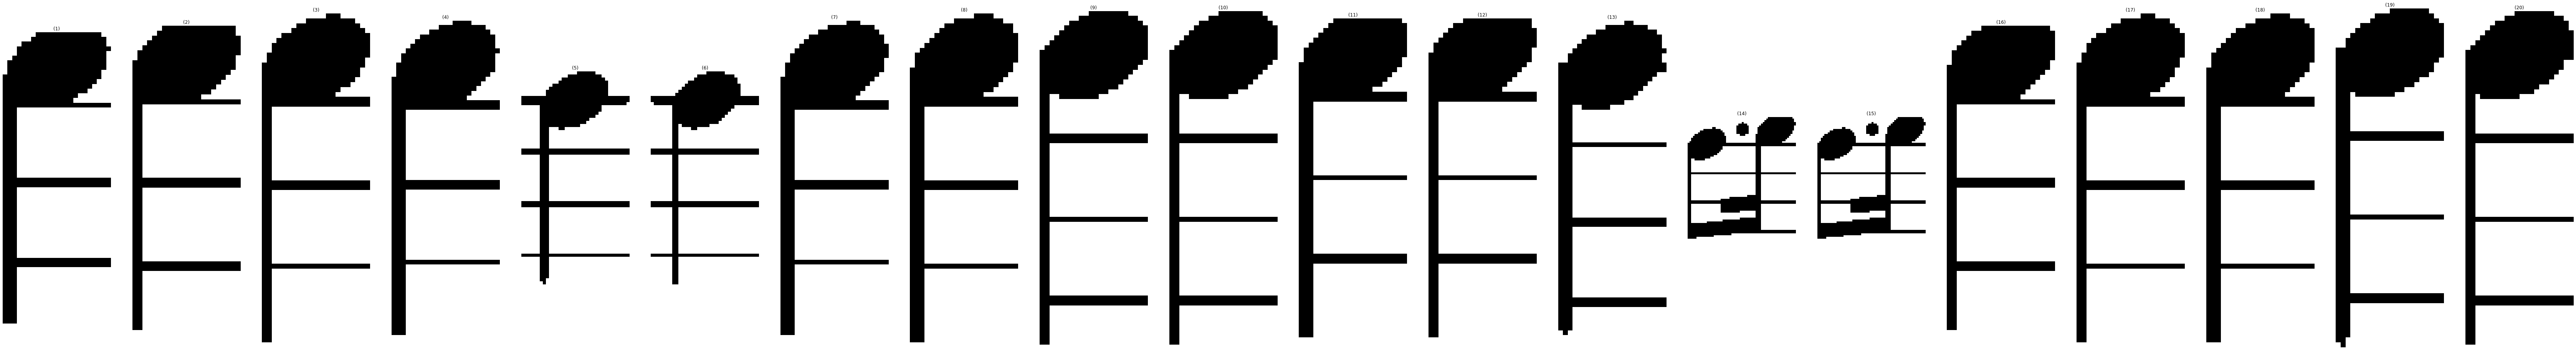

In [10]:
#view some images
show_images(all_images_arr[:20])

In [11]:
#check that all lengths match
len(all_images_labels) == len(all_images_arr) == len(all_images_ids)

True

In [12]:
#Store the data in a dataframe
df = pd.DataFrame(data= {'ID':all_images_ids, 'img': all_images_arr, 'label': all_images_labels})
df.head()

,ID,img,label
0,0,"[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",c4
1,0,"[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",c4
2,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...",g4
3,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...",g4
4,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",a4


In [13]:
df.shape

(44980, 3)

In [14]:
#creating a column for each unique label
unique_labels = df.label.unique()
for label in unique_labels:
    df[label] = 0
df.head()

,ID,img,label,c4,g4,a4,f4,e4,d4,a3,N0,b4,b3,e3,g3,f3,d3,c3
0,0,"[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",c4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,"[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",c4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...",g4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...",g4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",a4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#filling each column with the corresponding label
for i, label in enumerate(df.label):
    df[label][i] = 1
df.head()

,ID,img,label,c4,g4,a4,f4,e4,d4,a3,N0,b4,b3,e3,g3,f3,d3,c3
0,0,"[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",c4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,"[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",c4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...",g4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...",g4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",a4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Unifing The Shape of Each Image

In [16]:
def unify_shape(df):
    rows, cols = [], []
    for image in df.img:
        rows.append(image.shape[0])
        cols.append(image.shape[1])
    
    rows = max(rows)
    cols = max(cols)
    for i in range(len(df)):
        add_rows = np.ones((rows - df['img'][i].shape[0], df['img'][i].shape[1]), dtype = int)
        df['img'][i] = np.vstack((df['img'][i], add_rows))

        add_cols = np.ones((rows, cols - df['img'][i].shape[1]), dtype = int)
        df['img'][i] = np.hstack((df['img'][i], add_cols))
    return df, rows, cols

In [17]:
df, rows, cols = unify_shape(df)

In [18]:
#checking shapes
for x in df.img[:5]:
    print(x.shape)

(181, 285)
(181, 285)
(181, 285)
(181, 285)
(181, 285)


## Modeling

In [19]:
#split the data based on the number of images -> each music sheet
train_data = df[df.ID >= int(df.ID.nunique() * 0.2)]
test_data = df[df.ID < int(df.ID.nunique() * 0.2)]

In [20]:
X_train, y_train = train_data['img'], np.asarray(train_data.drop(columns=['ID','img','label']))
X_test, y_test = test_data['img'], np.asarray(test_data.drop(columns=['ID','img','label']))

In [21]:
def reshape_x(X):
    return np.asarray([x.reshape((rows, cols, 1)) for x in X])

In [22]:
X_train = reshape_x(X_train)
X_train.shape

(35842, 181, 285, 1)

In [23]:
y_train.shape

(35842, 15)

In [24]:
X_test = reshape_x(X_test)
X_test.shape

(9138, 181, 285, 1)

In [25]:
y_test.shape

(9138, 15)

In [26]:
NN = Sequential()
NN.add(InputLayer(input_shape=X_train.shape[1:]))
NN.add(Conv2D(filters=16, kernel_size=5, activation='relu'))
NN.add(MaxPooling2D())
NN.add(Conv2D(filters=32, kernel_size=5, activation='relu'))
NN.add(MaxPooling2D())
NN.add(Conv2D(filters=64, kernel_size=5, activation='relu'))
NN.add(MaxPooling2D())
NN.add(Conv2D(filters=128, kernel_size=5, activation='relu'))
NN.add(MaxPooling2D())
NN.add(Conv2D(filters=256, kernel_size=5, activation='relu'))
NN.add(GlobalAveragePooling2D())
NN.add(Dense(512 , activation='relu'))
NN.add(Dense(df.label.nunique() , activation='softmax'))

#compile is back propagation to edit the weight
NN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 281, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 140, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 136, 32)       12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 68, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 64, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 32, 64)       0

In [27]:
NN.fit(X_train, y_train, epochs=30, verbose=1, validation_split=0.25);

Epoch 1/30
841/841 [==============================] - 1216s 1s/step - loss: 1.7194 - accuracy: 0.3280 - val_loss: 0.9245 - val_accuracy: 0.5767
Epoch 2/30
841/841 [==============================] - 1206s 1s/step - loss: 0.8437 - accuracy: 0.5886 - val_loss: 0.7526 - val_accuracy: 0.5899
Epoch 3/30
841/841 [==============================] - 1199s 1s/step - loss: 0.6958 - accuracy: 0.6671 - val_loss: 0.5431 - val_accuracy: 0.7453
Epoch 4/30
841/841 [==============================] - 1202s 1s/step - loss: 0.5626 - accuracy: 0.7330 - val_loss: 0.5127 - val_accuracy: 0.7558
Epoch 5/30
841/841 [==============================] - 1202s 1s/step - loss: 0.5373 - accuracy: 0.7353 - val_loss: 0.4996 - val_accuracy: 0.7571
Epoch 6/30
841/841 [==============================] - 1205s 1s/step - loss: 0.5191 - accuracy: 0.7418 - val_loss: 0.4883 - val_accuracy: 0.7569
Epoch 7/30
841/841 [==============================] - 1201s 1s/step - loss: 0.5024 - accuracy: 0.7442 - val_loss: 0.4910 - val_accuracy:

In [28]:
#storing the predictions
results = []
pred = NN.predict(X_test)
for p in pred:
    results.append(unique_labels[np.argmax(p)])
print(results[:50])

['b3', 'd4', 'c4', 'c4', 'g3', 'g3', 'c4', 'c4', 'f4', 'f4', 'g4', 'g4', 'f4', 'a4', 'a4', 'd4', 'a3', 'c4', 'f4', 'f4', 'g4', 'g4', 'f4', 'f4', 'a3', 'c4', 'f4', 'f4', 'g4', 'a4', 'a4', 'a3', 'a4', 'N0', 'a4', 'a4', 'N0', 'a4', 'N0', 'e4', 'a4', 'f4', 'b3', 'e4', 'a3', 'N0', 'e4', 'a3', 'e4', 'a4']


In [29]:
print('The test accuracy is', round(NN.evaluate(X_test, y_test, verbose=0)[1] * 100, 2),'%')

The test accuracy is 71.77 %


In [30]:
#storing the list of predicted notes for each sheet (image)
IDs = list(test_data.ID)
num_of_notes = IDs.count(0) #for the first image
results_dict = {}
results_dict[0] = results[:num_of_notes]
for i in range(test_data.ID.nunique() - 1):
    results_dict[i+1] = results[num_of_notes : num_of_notes + IDs.count(i+1)]
    num_of_notes += IDs.count(i+1)

In [31]:
print(results_dict[0]) #predicted notes of the first image

['b3', 'd4', 'c4', 'c4', 'g3', 'g3', 'c4', 'c4', 'f4', 'f4', 'g4', 'g4', 'f4', 'a4', 'a4', 'd4', 'a3', 'c4', 'f4', 'f4', 'g4', 'g4', 'f4', 'f4', 'a3', 'c4', 'f4', 'f4', 'g4', 'a4', 'a4', 'a3', 'a4', 'N0', 'a4', 'a4', 'N0', 'a4', 'N0', 'e4', 'a4', 'f4', 'b3', 'e4', 'a3', 'N0', 'e4', 'a3', 'e4', 'a4', 'e4', 'e4', 'e4', 'N0', 'e4', 'a3', 'e4', 'a4', 'a4', 'a4']


# Producing Music

## Getting The Frequency of each Note

In [32]:
#getting the notes and frequencies from wikipedia
page = requests.get('https://en.wikipedia.org/wiki/Piano_key_frequencies')
soup = BeautifulSoup(page.content, "html.parser")

In [33]:
#initializing with a Quarter Note Rest, which has a 0 frequency
note = ['N0']
frequency = ['0']
for i, row in enumerate(soup.find('table', class_="wikitable sortable").find_all('tr')):
    if i < 2: #skipping the headers
        continue
    note.append(row.find_all('td')[3].text.strip().lower()) #third element is the note    
    frequency.append(row.find_all('td')[4].text.strip()) #fourth element is the note

In [34]:
#Store the data in a dataframe
frequency_df = pd.DataFrame(data= {'note':note, 'frequency': frequency})
frequency_df.head()

,note,frequency
0,N0,0
1,b8,7902.133
2,a♯8/b♭8,7458.620
3,a8,7040.000
4,g♯8/a♭8,6644.875


In [35]:
#getting the list of labels
original_labels_df = pd.DataFrame.from_dict(label_map, orient='index').reset_index(drop=True)
original_labels_list = list(original_labels_df[0]) + list(original_labels_df[1][1:])
print(original_labels_list)

['N0', 'b4', 'g4', 'e4', 'c4', 'a3', 'f3', 'd3', 'a4', 'f4', 'd4', 'b3', 'g3', 'e3', 'c3']


In [36]:
#collecting the index of the notes that are not in our labels list
idx_to_drop = []
for i, note in enumerate(frequency_df.note):
    if note.split()[0] not in original_labels_list:
        idx_to_drop.append(i)

In [37]:
#dropping the notes that are not in our labels list
frequency_df = frequency_df.drop(index=idx_to_drop).reset_index(drop=True)
frequency_df

,note,frequency
0,N0,0
1,b4,493.8833
2,a4 a440,440.0000
3,g4,391.9954
4,f4,349.2282
5,e4,329.6276
6,d4,293.6648
7,c4 middle c,261.6256
8,b3,246.9417
9,a3,220.0000


In [38]:
#manually clean two rows
frequency_df.iloc[2].note = 'a4'
frequency_df.iloc[7].note = 'c4'
frequency_df

,note,frequency
0,N0,0
1,b4,493.8833
2,a4,440.0000
3,g4,391.9954
4,f4,349.2282
5,e4,329.6276
6,d4,293.6648
7,c4,261.6256
8,b3,246.9417
9,a3,220.0000


In [39]:
#check that both lengths match
len(original_labels_list) == len(frequency_df)

True

## Creating Waves

In [40]:
#from the official documentation of SciPy
samplerate = 44100 #Frequecy in Hz
amplitude = np.iinfo(np.int16).max
t = np.linspace(0., 0.5, int(samplerate * 0.5))

In [41]:
#producing the music of the first sheet
waves = []
for note in results_dict[0]:
    freq = float(frequency_df[frequency_df.note == note].frequency.values[0])
    wave = amplitude * np.sin(2 * np.pi * freq * t)
    waves.append(wave)
song_data = np.concatenate(waves)

In [42]:
#outputs a wav audio file of the song
write('song.wav', samplerate, song_data.astype(np.int16))